In [1]:
from typing_extensions import Literal

import pandas as pd
import numpy as np
import scipy
from scipy.stats import chi2_contingency
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graphviz
import copy
from scipy import optimize
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
import datetime

In [7]:
def calc_chi_square(observed, expected):
    n = 0
    statistic = 0
    for i in range(observed.shape[0]):
        if (observed[i] == 0) and (expected[i] == 0):
            pass
        elif expected[i] == 0:
            n += 1
            statistic += (observed[i] - np.min(expected[expected>0]) * 0.01) ** 2 / (np.min(expected[expected>0]) * 0.01)
        else:
            n += 1
            statistic += (observed[i] - expected[i]) ** 2 / (expected[i])
    return statistic, n

def calc_log_dev(observed, expected):
    dev = []
    for i in range(observed.shape[0]):
        if (observed[i] == 0) and (expected[i] == 0):
            pass
        elif expected[i] == 0:
            dev.append(np.log2(observed[i] / (np.min(expected[expected>0]) * 0.01)))
        elif observed[i] == 0:
            dev.append(np.log2((np.min(observed[observed>0]) * 0.01) / (expected[i])))
        else:
            dev.append(np.log2(observed[i] / expected[i]))
    return np.mean(dev)

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Preprocess

In [8]:
merged_data = pd.DataFrame(columns = ["Aligned_Sequence", "Reference_Sequence", "#Reads", "%Reads",
                                     "timepoint", "iter", "A115_DMSO", "type"])

target_seqs = pd.read_csv("D:\\אוניברסיטה\\מעבדה\\BEanalysis\\target-site_sequences.csv")
path = "D:\\אוניברסיטה\\מעבדה\\BEanalysis\\BEanalysis-main"
os.chdir(path)
all_timepoints = ["_1hr", "_2hr", "_4hr", "_8hr", "_12hr", "_24hr"]
DMSO_A115 = ["A115", "DMSO"]


all_edit_types = [name for name in os.listdir(".") if os.path.isdir(name)]
for cur_edit_type in all_edit_types:

    
    
    os.chdir(cur_edit_type)
    
    ##add hr==0
    for folder in os.listdir("."):
        if "_0hr_" in folder:
            os.chdir(folder)
            for doc in os.listdir("."):
                if "Alleles_frequency_table_around_" in doc:
                    cur_freq_table = pd.read_csv(doc, sep = "\t")
                    
                    all_ref_seqs_trunc = []
                    all_ali_seqs_trunc = []

                    for i in range(cur_freq_table.shape[0]):
                        cur_target_seq = target_seqs[target_seqs["Target site"] == cur_edit_type[cur_edit_type.find("_") + 1:]]["Target sequence"].iloc[0]
                        cur_trunc_loc = cur_freq_table["Reference_Sequence"].iloc[i].find(cur_target_seq)
                        all_ref_seqs_trunc.append(cur_freq_table["Reference_Sequence"].iloc[i][cur_trunc_loc:cur_trunc_loc + len(cur_target_seq)])
                        all_ali_seqs_trunc.append(cur_freq_table["Aligned_Sequence"].iloc[i][cur_trunc_loc:cur_trunc_loc + len(cur_target_seq)])
                    cur_freq_table["Reference_Sequence"] =  all_ref_seqs_trunc
                    cur_freq_table["Aligned_Sequence"] = all_ali_seqs_trunc
                    cur_freq_table = cur_freq_table.groupby(by = ["Aligned_Sequence", "Reference_Sequence", "Unedited", "n_deleted", "n_inserted","n_mutated"]).sum().reset_index()
                    
                    cur_freq_table = cur_freq_table[cur_freq_table["%Reads"] >= 0.1]
                    cur_freq_table["%Reads"] = cur_freq_table["%Reads"] / cur_freq_table["%Reads"].sum()
                    cur_freq_table = cur_freq_table[["Aligned_Sequence", "Reference_Sequence", "#Reads", "%Reads"]]
                    cur_freq_table["timepoint"] = 0
                    cur_freq_table["iter"] = int(folder[-1])
                    cur_freq_table["A115_DMSO"] = "0hr"
                    cur_freq_table["type"] = cur_edit_type
                    merged_data = merged_data.append(cur_freq_table)
            os.chdir("..")
        
    
    for item in DMSO_A115:
        
        all_current_item_exps = [name for name in os.listdir(".") if item in name]
        all_current_item_exps_dict = {1:[], 2:[], 3:[]}
        [all_current_item_exps_dict[int(exp[-1])].append(exp) for exp in all_current_item_exps]

        for cur_rep in all_current_item_exps_dict.keys():

            cur_iter_data = all_current_item_exps_dict[cur_rep]

            for cur_timepoint in all_timepoints:
                for folder in cur_iter_data:
                    
                    if cur_timepoint in folder:
                        os.chdir(folder)

                for doc in os.listdir("."):
                    if "Alleles_frequency_table_around_" in doc:
                        cur_freq_table = pd.read_csv(doc, sep = "\t")
                        
                        all_ref_seqs_trunc = []
                        all_ali_seqs_trunc = []

                        for i in range(cur_freq_table.shape[0]):
                            cur_target_seq = target_seqs[target_seqs["Target site"] == cur_edit_type[cur_edit_type.find("_") + 1:]]["Target sequence"].iloc[0]
                            cur_trunc_loc = cur_freq_table["Reference_Sequence"].iloc[i].find(cur_target_seq)
                            all_ref_seqs_trunc.append(cur_freq_table["Reference_Sequence"].iloc[i][cur_trunc_loc:cur_trunc_loc + len(cur_target_seq)])
                            all_ali_seqs_trunc.append(cur_freq_table["Aligned_Sequence"].iloc[i][cur_trunc_loc:cur_trunc_loc + len(cur_target_seq)])
                        cur_freq_table["Reference_Sequence"] =  all_ref_seqs_trunc
                        cur_freq_table["Aligned_Sequence"] = all_ali_seqs_trunc
                        cur_freq_table = cur_freq_table.groupby(by = ["Aligned_Sequence", "Reference_Sequence", "Unedited", "n_deleted", "n_inserted","n_mutated"]).sum().reset_index()
                        
                        cur_freq_table = cur_freq_table[cur_freq_table["%Reads"] >= 0.1]
                        cur_freq_table["%Reads"] = cur_freq_table["%Reads"] / cur_freq_table["%Reads"].sum()
                        cur_freq_table = cur_freq_table[["Aligned_Sequence", "Reference_Sequence", "#Reads", "%Reads"]]
                        cur_freq_table["timepoint"] = int(cur_timepoint[1:cur_timepoint.index("hr")])
                        cur_freq_table["iter"] = cur_rep
                        cur_freq_table["A115_DMSO"] = item
                        cur_freq_table["type"] = cur_edit_type
                        merged_data = merged_data.append(cur_freq_table)
                
                os.chdir("..")
                
    
    os.chdir("..")

In [9]:
merged_data[["Reference_Sequence", "type"]].groupby(by=["Reference_Sequence", "type"]).sum()


Empty DataFrame
Columns: []
Index: [(GAACACAAAGCATAGACTGC, ABE8e_HEK2), (GAACACAAAGCATAGACTGC, ABEmax_HEK2), (GAACACAAAGCATAGACTGC, BE4max_HEK2), (GAAGACCAAGGATAGACTGC, ABE8e_ABE9), (GAAGACCAAGGATAGACTGC, ABEmax_ABE9), (GAAGACCAAGGATAGACTGC, BE4max_ABE9), (GAGTCCGAGCAGAAGAAGAA, BE4max_EMX1), (GGCCCAGACTGAGCACGTGA, ABE8e_HEK3), (GGCCCAGACTGAGCACGTGA, ABEmax_HEK3), (GGCCCAGACTGAGCACGTGA, BE4max_HEK3), (GGGAATAAATCATAGAATCC, ABE8e_ABE16), (GGGAATAAATCATAGAATCC, ABEmax_ABE16)]

In [10]:
all_reads_agg = pd.DataFrame(columns = ["type", "A115_DMSO", "iter", "Aligned_Sequence", "Reference_Sequence"])
all_reads_agg = all_reads_agg.set_index(["type", "A115_DMSO", "iter", "Aligned_Sequence", "Reference_Sequence"])
for time in set(merged_data["timepoint"]):
    tmp_data = merged_data[merged_data["timepoint"] == time]
    tmp_data = tmp_data[["Aligned_Sequence", "Reference_Sequence", "%Reads", "iter", "A115_DMSO", "type"]]
    tmp_data.columns = ["Aligned_Sequence", "Reference_Sequence", time, "iter", "A115_DMSO", "type"]
    all_reads_agg = all_reads_agg.merge(tmp_data, on = ["type", "A115_DMSO", "iter", "Aligned_Sequence", "Reference_Sequence"], how = "outer")
all_reads_agg = all_reads_agg.fillna(0)
all_reads_agg = all_reads_agg.groupby(by = ["Aligned_Sequence", "Reference_Sequence", "iter", "A115_DMSO", "type"]).max()


num_of_changes = []
changes_loc = []
for i in range(all_reads_agg.shape[0]):
    tmp_datapoint = all_reads_agg.iloc[i]
    cur_num_of_changes = 0
    cur_changes_loc = []
    for i in range(len(tmp_datapoint.name[0])):
        if tmp_datapoint.name[0][i] != tmp_datapoint.name[1][i]:
            cur_num_of_changes += 1
            cur_changes_loc.append(i)
    num_of_changes.append(cur_num_of_changes)
    changes_loc.append(cur_changes_loc)
all_reads_agg["num_of_changes"] = num_of_changes
all_reads_agg["changes_loc"] = changes_loc



all_reads_agg = all_reads_agg.reset_index() 

only_time_0 = all_reads_agg[all_reads_agg["A115_DMSO"] == "0hr"]
for i in range(only_time_0.shape[0]):
    cur_0_time = only_time_0.iloc[i]  
    tmp_change_loc = all_reads_agg[(all_reads_agg["A115_DMSO"] != "0hr") &
                  (all_reads_agg["type"] == cur_0_time["type"]) &
                  (all_reads_agg["iter"] == cur_0_time["iter"]) &
                  (all_reads_agg["Reference_Sequence"] == cur_0_time["Reference_Sequence"]) &
                  (all_reads_agg["Aligned_Sequence"] == cur_0_time["Aligned_Sequence"])].index
    for cur_loc in tmp_change_loc:
        all_reads_agg.loc[cur_loc, 0] = cur_0_time[0]

all_reads_agg = all_reads_agg[all_reads_agg["A115_DMSO"] != "0hr"]

all_reads_agg_copy = copy.deepcopy(all_reads_agg)
all_reads_agg_copy2 = copy.deepcopy(all_reads_agg)

for i in range(all_reads_agg.shape[0]):
    cur_work_line = all_reads_agg.iloc[i]
    cur_exp = all_reads_agg[(all_reads_agg["iter"] == cur_work_line["iter"]) & (all_reads_agg["A115_DMSO"] == cur_work_line["A115_DMSO"]) & (all_reads_agg["type"] == cur_work_line["type"]) & (all_reads_agg["Reference_Sequence"] == cur_work_line["Reference_Sequence"])]
    if cur_work_line["num_of_changes"] > 0:
        cur_all_changes = {}
        for change_loc in cur_work_line["changes_loc"]:
            cur_all_changes[change_loc] = cur_work_line["Aligned_Sequence"][change_loc]


        add_to_cur_abundance = []
        for j in range(cur_exp.shape[0]):
            tmp_add_to_cur_abundance = True
            tmp_line = cur_exp.iloc[j]
            for change_loc in cur_all_changes.keys():
                if tmp_line["Aligned_Sequence"][change_loc] != cur_all_changes[change_loc]:
                    tmp_add_to_cur_abundance = False

            add_to_cur_abundance.append(tmp_add_to_cur_abundance)
        for time in [0, 1, 2, 4, 8, 12, 24]:
            all_reads_agg_copy.loc[cur_work_line.name, time] = np.sum(cur_exp[add_to_cur_abundance][time])
all_reads_agg = all_reads_agg_copy

## Data Processing

In [118]:
all_expected = []
all_n = []
total_mc = 1000
p_val_mc = []
times_to_test = [1,2,4,8,12,24]
all_dev = []
pos_expected = []
all_distances = []
all_total_changes = []
all_changes_loc = []
seqs_p_vals_df = pd.DataFrame(columns = ["type", "iter", "A115_DMSO", "seq_A", "seq_B", 
                                         "Reference_Sequence","Both_changes", "chi_statistic", "n", 
                                         "p_val_mc", "pearson_r", "pearson_p"])


for cur_iter in range(1, 4):
    for cur_type in set(all_reads_agg["type"]):
        for cur_A115_DMSO in (["DMSO", "A115"]):
            print(datetime.datetime.now(), cur_iter, cur_type, cur_A115_DMSO)
            tmp_data = all_reads_agg[(all_reads_agg["iter"] == cur_iter) & (all_reads_agg["A115_DMSO"] == cur_A115_DMSO) & (all_reads_agg["type"] == cur_type)]
            tmp_data = tmp_data.drop(["iter", "A115_DMSO", "type"], axis = 1)
            tmp_data_singletons= tmp_data[(tmp_data["num_of_changes"] <= 2) & (tmp_data["num_of_changes"] > 0)]
            samples_for_p_values = []
            
            i = 0
            while i< total_mc:
                cur_sample_for_p_val = []
                cur_sample_for_p_val_obs = []
                for timepoint in times_to_test:
                    
                    cur_sample_for_p_val.append(float(tmp_data_singletons[timepoint].sample(1)) * float(tmp_data_singletons[timepoint].sample(1)))
                    cur_sample_for_p_val_obs.append(float(tmp_data[timepoint].sample(1)))
                
                if (np.sum(cur_sample_for_p_val) > 0) and (np.sum(cur_sample_for_p_val_obs) > 0):
                    tmp_chi = calc_chi_square(np.array(cur_sample_for_p_val), np.array(cur_sample_for_p_val_obs))
                    samples_for_p_values.append(tmp_chi[0] / tmp_chi[1])
                    i += 1
            
            
            for i in range(tmp_data_singletons.shape[0] - 1):
                for j in range(i + 1, tmp_data_singletons.shape[0]):
                    if len(set(tmp_data_singletons.iloc[i]["changes_loc"]) & set(tmp_data_singletons.iloc[j]["changes_loc"])) == 0:
                        tmp_first_singleton = tmp_data_singletons.iloc[i]
                        tmp_second_singleton = tmp_data_singletons.iloc[j]
                        
                        
                        
                        multi_change = list(tmp_first_singleton["Reference_Sequence"])
                        for loc in tmp_first_singleton["changes_loc"]:
                            multi_change[loc] = tmp_first_singleton["Aligned_Sequence"][loc]
                        for loc in tmp_second_singleton["changes_loc"]:
                            multi_change[loc] = tmp_second_singleton["Aligned_Sequence"][loc]

                        multi_change = ''.join(multi_change)
                        
                        if tmp_data[tmp_data["Aligned_Sequence"] == multi_change].shape[0] > 0:
                            
                            cur_obs_values = tmp_data[tmp_data["Aligned_Sequence"] == multi_change][times_to_test]
                            expected = tmp_first_singleton[times_to_test] * tmp_second_singleton[times_to_test]
                            if np.sum(expected) > 0:
                                
                                cur_obs_values_for_cor = difference(np.array(cur_obs_values).tolist()[0], 2)
                                expected_for_cor = difference(expected.tolist(), 2)
                                
                                
                                cur_pearson_r, cur_pearson_p = scipy.stats.pearsonr(cur_obs_values_for_cor, expected_for_cor)
                                
                                cur_chi, cur_n = calc_chi_square(np.array(cur_obs_values)[0], np.array(expected))
                                cur_changes_loc = [i for i in tmp_first_singleton["changes_loc"]]
                                [cur_changes_loc.append(i) for i in tmp_second_singleton["changes_loc"]]
                                if cur_n >= 1:
                                    all_changes_loc.append(cur_changes_loc)
                                    all_expected.append(cur_chi)
                                    all_n.append(cur_n)
                                    all_dev.append(calc_log_dev(np.array(cur_obs_values)[0], np.array(expected)))

                                    pos_expected.append(np.sum(expected > 0))
                                    p_val_mc.append(np.sum(cur_chi / cur_n > np.array(samples_for_p_values)) / total_mc)
                                    tmp_dict = {"type":cur_type, "iter": cur_iter, "A115_DMSO": cur_A115_DMSO,
                                                "seq_A":tmp_first_singleton["Aligned_Sequence"], 
                                                "seq_B":tmp_second_singleton["Aligned_Sequence"], 
                                                "Reference_Sequence": tmp_first_singleton["Reference_Sequence"], 
                                                "Both_changes": multi_change,
                                                "chi_statistic": cur_chi, "n": cur_n, "p_val_mc": p_val_mc[-1], 
                                                "pearson_r" : cur_pearson_r, "pearson_p" : cur_pearson_p}
                                    seqs_p_vals_df = seqs_p_vals_df.append(tmp_dict, ignore_index = True)
                                    all_total_changes.append(tmp_first_singleton["num_of_changes"] + tmp_second_singleton["num_of_changes"])
                                    all_distances.append(np.abs(tmp_first_singleton["changes_loc"][0] - tmp_second_singleton["changes_loc"][0]))
                                
                                
                            
                            
p_vals = []
for i in range(seqs_p_vals_df.shape[0]):
    p_vals.append(1 - scipy.stats.chi2.cdf(seqs_p_vals_df.iloc[i]["chi_statistic"], seqs_p_vals_df.iloc[i]["n"] - 1))
seqs_p_vals_df["p_vals"] = p_vals

seqs_p_vals_df["dev"] = all_dev

seqs_p_vals_df["pos_expected"] = pos_expected
seqs_p_vals_df["num_of_changes"] = all_total_changes
seqs_p_vals_df["distance"] = all_distances
seqs_p_vals_df["changes_loc"] = all_changes_loc
seqs_p_vals_df = seqs_p_vals_df[seqs_p_vals_df["num_of_changes"] == 2]



2022-02-28 20:20:56.392399 1 ABEmax_HEK2 DMSO
2022-02-28 20:20:58.471874 1 ABEmax_HEK2 A115
2022-02-28 20:21:00.973157 1 BE4max_HEK2 DMSO
2022-02-28 20:21:03.183282 1 BE4max_HEK2 A115
2022-02-28 20:21:05.749424 1 BE4max_HEK3 DMSO
2022-02-28 20:21:08.175939 1 BE4max_HEK3 A115
2022-02-28 20:21:10.902620 1 ABE8e_HEK2 DMSO
2022-02-28 20:21:13.106718 1 ABE8e_HEK2 A115
2022-02-28 20:21:15.437482 1 ABEmax_ABE9 DMSO
2022-02-28 20:21:17.509943 1 ABEmax_ABE9 A115
2022-02-28 20:21:19.737988 1 ABE8e_HEK3 DMSO
2022-02-28 20:21:22.168462 1 ABE8e_HEK3 A115
2022-02-28 20:21:24.596008 1 ABEmax_HEK3 DMSO
2022-02-28 20:21:26.966558 1 ABEmax_HEK3 A115
2022-02-28 20:21:29.458893 1 ABE8e_ABE16 DMSO
2022-02-28 20:21:32.188629 1 ABE8e_ABE16 A115
2022-02-28 20:21:34.589184 1 ABE8e_ABE9 DMSO
2022-02-28 20:21:36.946912 1 ABE8e_ABE9 A115
2022-02-28 20:21:39.184900 1 BE4max_ABE9 DMSO
2022-02-28 20:21:41.483756 1 BE4max_ABE9 A115
2022-02-28 20:21:43.456486 1 BE4max_EMX1 DMSO
2022-02-28 20:21:45.864081 1 BE4max_EMX1

In [122]:
seqs_p_vals_df.to_csv("D:\\אוניברסיטה\\מעבדה\\BEanalysis\\results\chi_table.csv")

## Independence Analysis

In [116]:
seqs_p_vals_df_large_n = seqs_p_vals_df[(seqs_p_vals_df["pos_expected"] >= 3)]

print(seqs_p_vals_df_large_n.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).count().shape)
seqs_p_vals_df_large_n["FDR"] = fdrcorrection(seqs_p_vals_df_large_n["p_vals"])[1]
seqs_p_vals_df_large_n["chi_statistic_corrected"] = seqs_p_vals_df_large_n["chi_statistic"] / seqs_p_vals_df_large_n["n"]
seqs_p_vals_df_large_n["chi_statistic_corrected"] = seqs_p_vals_df_large_n["chi_statistic_corrected"].astype(float)
# seqs_p_vals_df_large_n_sig = seqs_p_vals_df_large_n[seqs_p_vals_df_large_n["dev"] >= 1]
seqs_p_vals_df_large_n_sig = seqs_p_vals_df_large_n[seqs_p_vals_df_large_n["chi_statistic_corrected"] > 0.045]

seqs_p_vals_df_large_n_sig_count = seqs_p_vals_df_large_n_sig.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).count()
seqs_p_vals_df_large_n_sig_mean = seqs_p_vals_df_large_n_sig.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()
seqs_p_vals_df_large_n_sig_count["dev"] = seqs_p_vals_df_large_n_sig_mean["dev"]
seqs_p_vals_df_large_n_sig_count["pearson_p"] = seqs_p_vals_df_large_n_sig_mean["pearson_p"]
seqs_p_vals_df_large_n_sig_count["pearson_r"] = seqs_p_vals_df_large_n_sig_mean["pearson_r"]
seqs_p_vals_df_large_n_sig_count["FDR"] = seqs_p_vals_df_large_n_sig_mean["FDR"]
seqs_p_vals_df_large_n_sig_count["distance"] = seqs_p_vals_df_large_n_sig_mean["distance"]
seqs_p_vals_df_large_n_sig_count["num_of_changes"] = seqs_p_vals_df_large_n_sig_mean["num_of_changes"]
seqs_p_vals_df_large_n_sig_count["changes_loc"] = seqs_p_vals_df_large_n_sig.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).agg({'changes_loc': 'sum'})["changes_loc"]
print(seqs_p_vals_df_large_n_sig.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).count().shape)

seqs_p_vals_df_large_n_sig_count = seqs_p_vals_df_large_n_sig_count[seqs_p_vals_df_large_n_sig_count["iter"] >= 2]
print(seqs_p_vals_df_large_n_sig_count.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).count().shape)
seqs_p_vals_df_large_n_sig_count


seqs_p_vals_df_large_n_sig_count.drop(["chi_statistic", "n","p_val_mc","p_vals", "pos_expected"], inplace = True, axis = 1)
seqs_p_vals_df_large_n_sig_count = seqs_p_vals_df_large_n_sig_count.reset_index()
seqs_p_vals_df_large_n_sig_count


(36, 12)
(25, 14)


C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/2147860577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs_p_vals_df_large_n["FDR"] = fdrcorrection(seqs_p_vals_df_large_n["p_vals"])[1]
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/2147860577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs_p_vals_df_large_n["chi_statistic_corrected"] = seqs_p_vals_df_large_n["chi_statistic"] / seqs_p_vals_df_large_n["n"]
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/2147860577.py:6: SettingWithCop

(22, 14)


,type,A115_DMSO,seq_A,seq_B,Reference_Sequence,Both_changes,iter,pearson_r,pearson_p,dev,num_of_changes,distance,changes_loc,FDR,chi_statistic_corrected
0,ABE8e_ABE16,A115,GGGAATGAATCATAGAATCC,GGGAGTAAATCATAGAATCC,GGGAATAAATCATAGAATCC,GGGAGTGAATCATAGAATCC,3,0.943483,0.056517,4.331483,2.0,2.0,"[6, 4, 6, 4, 6, 4]",1.0,3
1,ABE8e_ABE16,A115,GGGAGTAAATCATAGAATCC,GGGGATAAATCATAGAATCC,GGGAATAAATCATAGAATCC,GGGGGTAAATCATAGAATCC,2,0.950145,0.049855,4.268870,2.0,1.0,"[4, 3, 4, 3]",1.0,2
2,ABE8e_ABE16,DMSO,GGGAATGAATCATAGAATCC,GGGAGTAAATCATAGAATCC,GGGAATAAATCATAGAATCC,GGGAGTGAATCATAGAATCC,3,0.931083,0.068917,5.312939,2.0,2.0,"[6, 4, 6, 4, 6, 4]",1.0,3
3,ABE8e_ABE16,DMSO,GGGAGTAAATCATAGAATCC,GGGGATAAATCATAGAATCC,GGGAATAAATCATAGAATCC,GGGGGTAAATCATAGAATCC,3,0.908242,0.091758,5.251951,2.0,1.0,"[4, 3, 4, 3, 4, 3]",1.0,3
4,ABE8e_ABE9,A115,GAAGACCGAGGATAGACTGC,GAAGGCCAAGGATAGACTGC,GAAGACCAAGGATAGACTGC,GAAGGCCGAGGATAGACTGC,3,0.949820,0.050180,3.370966,2.0,3.0,"[7, 4, 7, 4, 7, 4]",1.0,3
5,ABE8e_ABE9,DMSO,GAAGACCGAGGATAGACTGC,GAAGGCCAAGGATAGACTGC,GAAGACCAAGGATAGACTGC,GAAGGCCGAGGATAGACTGC,2,0.974446,0.025554,2.788291,2.0,3.0,"[7, 4, 7, 4]",1.0,2
6,ABE8e_HEK2,A115,GAACACGAAGCATAGACTGC,GAACGCAAAGCATAGACTGC,GAACACAAAGCATAGACTGC,GAACGCGAAGCATAGACTGC,3,0.891501,0.108499,3.754840,2.0,2.0,"[6, 4, 6, 4, 6, 4]",1.0,3
7,ABE8e_HEK2,DMSO,GAACACGAAGCATAGACTGC,GAACGCAAAGCATAGACTGC,GAACACAAAGCATAGACTGC,GAACGCGAAGCATAGACTGC,3,0.957723,0.042277,4.863654,2.0,2.0,"[6, 4, 6, 4, 6, 4]",1.0,3
8,ABE8e_HEK3,A115,GGCCCAGGCTGAGCACGTGA,GGCCCGGACTGAGCACGTGA,GGCCCAGACTGAGCACGTGA,GGCCCGGGCTGAGCACGTGA,3,0.980681,0.019319,2.630065,2.0,2.0,"[7, 5, 7, 5, 7, 5]",1.0,3
9,ABE8e_HEK3,DMSO,GGCCCAGGCTGAGCACGTGA,GGCCCGGACTGAGCACGTGA,GGCCCAGACTGAGCACGTGA,GGCCCGGGCTGAGCACGTGA,3,0.985831,0.014169,2.778247,2.0,2.0,"[7, 5, 7, 5, 7, 5]",1.0,3


C:\Users\omrip\AppData\Local\Temp/ipykernel_8056/811562901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs_p_vals_df_large_n["chi_statistic_corrected"] = seqs_p_vals_df_large_n["chi_statistic"] / seqs_p_vals_df_large_n["n"]


(0.0, 1.0)

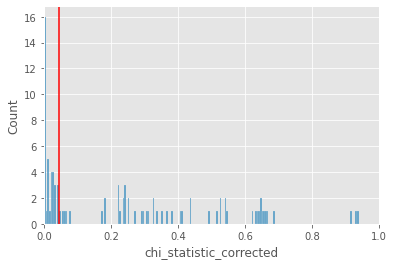

In [14]:

seqs_p_vals_df_large_n = seqs_p_vals_df[(seqs_p_vals_df["pos_expected"] >= 3)]
seqs_p_vals_df_large_n["chi_statistic_corrected"] = seqs_p_vals_df_large_n["chi_statistic"] / seqs_p_vals_df_large_n["n"]
seqs_p_vals_df_large_n["chi_statistic_corrected"]

sns.histplot(seqs_p_vals_df_large_n["chi_statistic_corrected"],binwidth = 0.005)
plt.axvline(x=0.045, color = "r")
plt.xlim(0, 1)



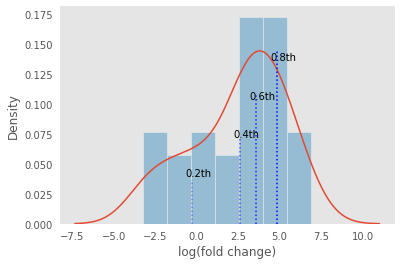

In [105]:
fig, ax = plt.subplots(figsize = (6,4))

mean_seqs_p_vals_df = seqs_p_vals_df_large_n.groupby(by = ["type","A115_DMSO", "seq_A", "seq_B", "Reference_Sequence", "Both_changes"]).mean().reset_index()
sns.histplot(mean_seqs_p_vals_df["dev"], stat = "density", alpha = 0.45)
sns.kdeplot(mean_seqs_p_vals_df["dev"])
ax.set_xlabel("log(fold change)")

ax.tick_params(left = False, bottom = False)
for ax2, spine in ax.spines.items():
    spine.set_visible(False)
ax.grid(False)

# quant_5, quant_25, quant_50, quant_75, quant_95 = avocado.quantile(0.05), avocado.quantile(0.25), avocado.quantile(0.5), avocado.quantile(0.75), avocado.quantile(0.95)

qunatiles = [0.2, 0.4, 0.6, 0.8]
for quantile in qunatiles:
    ax.axvline(np.quantile(mean_seqs_p_vals_df["dev"], quantile),
              alpha = quantile + 0.2, ymax = 1 * quantile, linestyle = ":", color = "blue")
    ax.text(np.quantile(mean_seqs_p_vals_df["dev"], quantile) - 0.4, 0.16 * quantile + 0.008,
           f"{quantile:.1}th")



In [164]:
np.sum(seqs_p_vals_df_large_n.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).min()["dev"] > 0)

28

In [11]:
dot = graphviz.Graph()

all_nodes_labels = {}

for i in range(seqs_p_vals_df_large_n_sig_count.shape[0]):
    seq_a = seqs_p_vals_df_large_n_sig_count.iloc[i]["seq_A"]
    seq_a_spaced = ""
    for j in range(4):
        seq_a_spaced += seq_a[j * 10:j * 10 + 10] +"\n"
    all_nodes_labels[seq_a] = seq_a_spaced
    
    seq_b = seqs_p_vals_df_large_n_sig_count.iloc[i]["seq_B"]
    seq_b_spaced = ""
    for j in range(4):
        seq_b_spaced += seq_b[j * 10:j * 10 + 10] +"\n"
    all_nodes_labels[seq_b] = seq_b_spaced
    
    


for node in all_nodes_labels.keys():
    dot.node(node, label = all_nodes_labels[node])
    

all_labels = {}
for i in range(seqs_p_vals_df_large_n_sig_count.shape[0]):
    seq_a = seqs_p_vals_df_large_n_sig_count.iloc[i]["seq_A"]
    seq_b = seqs_p_vals_df_large_n_sig_count.iloc[i]["seq_B"]
    cur_edge = sorted([seq_a, seq_b])
    cur_edge = cur_edge[0]+"\t"+cur_edge[1]
    
    cur_label = "%s, %s, %f" % (seqs_p_vals_df_large_n_sig_count.iloc[i]["type"], seqs_p_vals_df_large_n_sig_count.iloc[i]["A115_DMSO"], seqs_p_vals_df_large_n_sig_count.iloc[i]["dev"])
    
    if cur_edge in all_labels.keys():
        all_labels[cur_edge] = all_labels[cur_edge] + "\n" +cur_label
    else:
        all_labels[cur_edge] = cur_label
    
for edge in all_labels.keys():
    cur_edge = edge.split("\t")
    dot.edge(cur_edge[0], cur_edge[1], label = all_labels[edge])    
    
dot.render(view = True)


'Graph.gv.pdf'

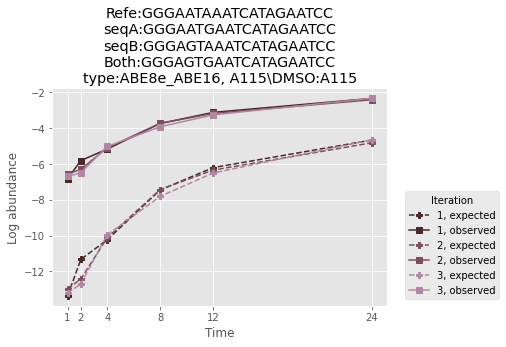

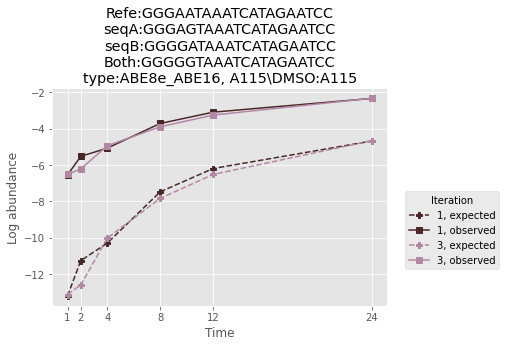

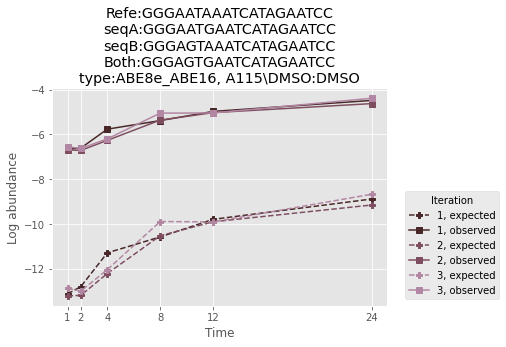

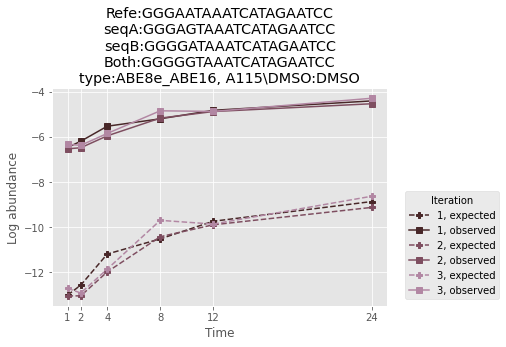

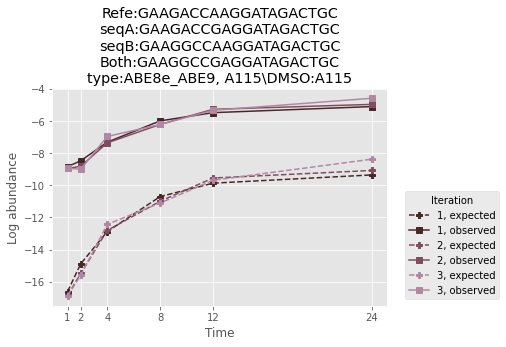

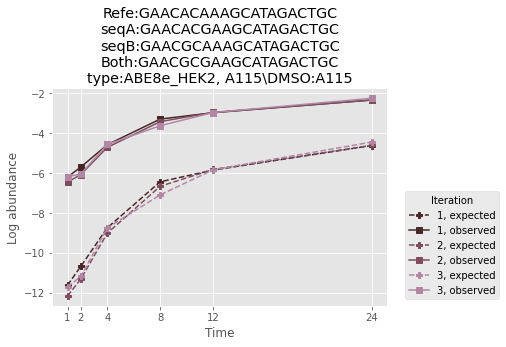

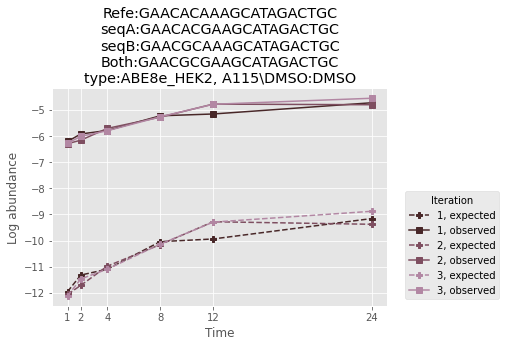

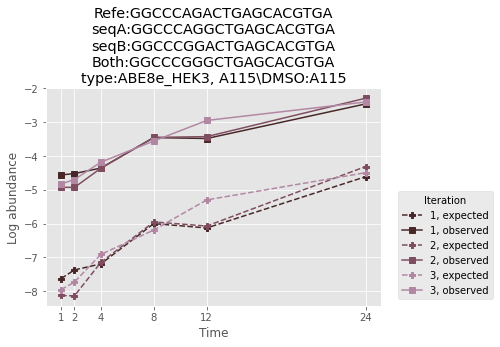

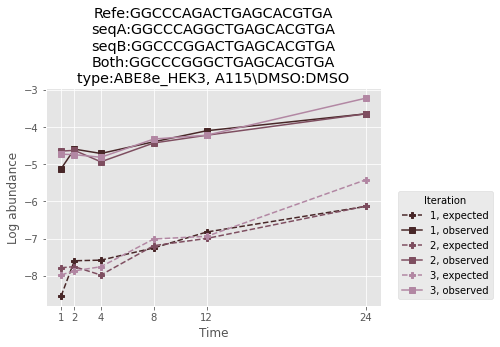

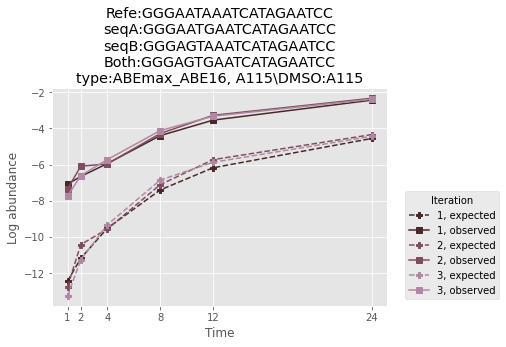

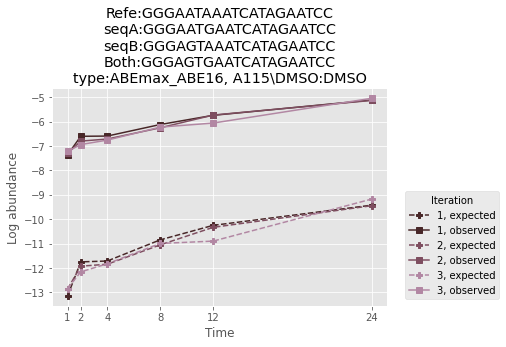

C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:23: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:23: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
C:\Users\omrip\AppData

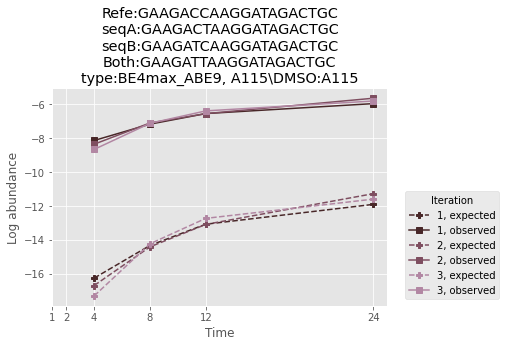

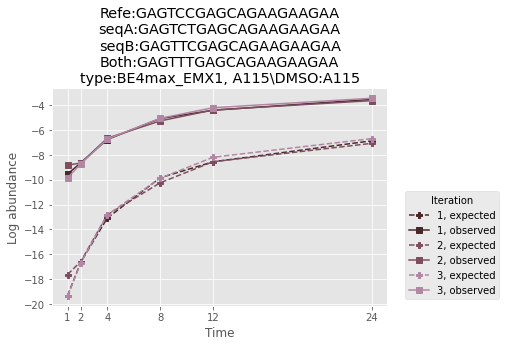

C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:23: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)


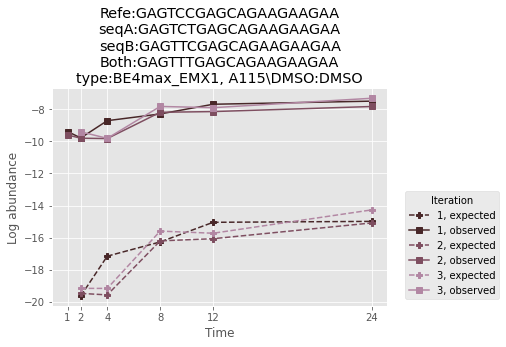

C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)


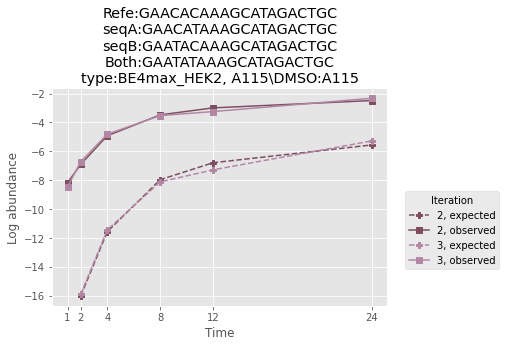

C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:23: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:22: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
C:\Users\omrip\AppData\Local\Temp/ipykernel_33756/1913844335.py:23: RuntimeWarning: divide by zero encountered in log2
  plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
C:\Users\omrip\AppData

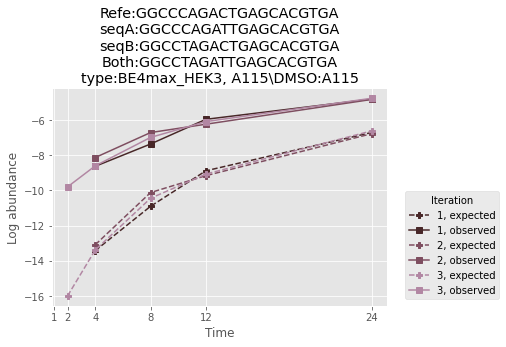

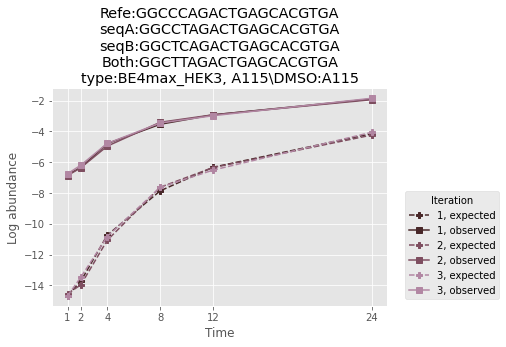

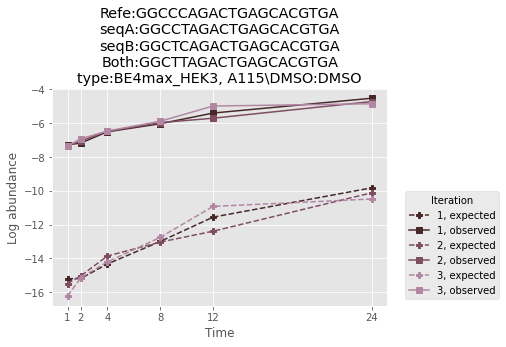

In [104]:

colors = [[72/255,39/255, 40/255], [126/255,78/255, 96/255], [178/255,135/255, 163/255]]
for i in range(seqs_p_vals_df_large_n_sig_count.shape[0]):
    plt.figure()
    cur_data = seqs_p_vals_df_large_n_sig_count.iloc[i] 
    cur_ref = cur_data["Reference_Sequence"]
    cur_seq_A = cur_data["seq_A"]
    cur_seq_B = cur_data["seq_B"]
    cur_both = cur_data["Both_changes"]
    cur_type = cur_data["type"]
    cur_A115_DMSO = cur_data["A115_DMSO"]
    cur_FDR = cur_data["FDR"]
    cur_dev = cur_data["dev"]

    for j in range(1, 4):
        seq_a_abundance = all_reads_agg[(all_reads_agg["Aligned_Sequence"] == cur_seq_A) & (all_reads_agg["type"] == cur_type) & (all_reads_agg["A115_DMSO"] == cur_A115_DMSO) & (all_reads_agg["iter"] == j)][times_to_test]
        seq_b_abundance = all_reads_agg[(all_reads_agg["Aligned_Sequence"] == cur_seq_B) & (all_reads_agg["type"] == cur_type) & (all_reads_agg["A115_DMSO"] == cur_A115_DMSO) & (all_reads_agg["iter"] == j)][times_to_test]
        both_changes_abundance = all_reads_agg[(all_reads_agg["Aligned_Sequence"] == cur_both) & (all_reads_agg["type"] == cur_type) & (all_reads_agg["A115_DMSO"] == cur_A115_DMSO) & (all_reads_agg["iter"] == j)][times_to_test]
        if (seq_a_abundance.shape[0] > 0) & (seq_b_abundance.shape[0] > 0) & (both_changes_abundance.shape[0] > 0):
            expected = list(np.array(seq_a_abundance)[0] * np.array(seq_b_abundance)[0])
#             plt.plot(times_to_test, np.log10(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
#             plt.plot(times_to_test, np.log10(list(np.array(seq_a_abundance)[0])), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
            plt.plot(times_to_test, np.log2(expected), color = colors[j - 1], ls = "--", marker = "P", label = "%d, expected" % j)
            plt.plot(times_to_test, np.log2(np.array(seq_a_abundance)[0]), color = colors[j - 1], marker = "s", label = "%d, observed" % j)
    plt.xticks(times_to_test, times_to_test)
    title = "Refe:%s\nseqA:%s\nseqB:%s\nBoth:%s\ntype:%s, A115\DMSO:%s" %(cur_ref, 
                                                                                          cur_seq_A, cur_seq_B, cur_both, 
                                                                                           cur_type, cur_A115_DMSO,
                                                                                          )
    plt.legend(loc='best', bbox_to_anchor=(0.85, 0., 0.5, 0.55), title = "Iteration")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Log abundance")
    plt.show()

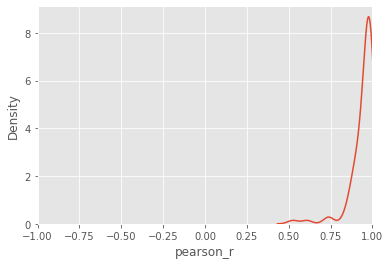

In [103]:
sns.kdeplot(seqs_p_vals_df[(seqs_p_vals_df["n"] >=3)]["pearson_r"])
plt.xlim(-1,1)
plt.style.use('ggplot')
plt.show()

## Distances

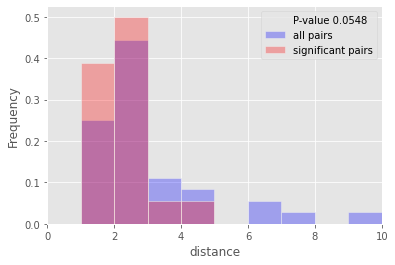

In [50]:
all_dist = seqs_p_vals_df[(seqs_p_vals_df["num_of_changes"] == 2) & (seqs_p_vals_df["pos_expected"] >= 3)]
all_dist = all_dist.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()["distance"]

sig_dist = seqs_p_vals_df_large_n_sig_count[seqs_p_vals_df_large_n_sig_count["num_of_changes"] == 2]["distance"]
# sns.kdeplot(all_dist, label = "all pairs")
# sns.kdeplot(sig_dist, label = "significant pairs")
sns.histplot(all_dist, bins=range(1, 30, 1), stat = "probability", label = "all pairs", color = "blue", alpha = 0.3)
sns.histplot(sig_dist, bins=range(1, 30, 1), stat = "probability", label = "significant pairs", color = "red", alpha = 0.3)

MW_p_val = scipy.stats.mannwhitneyu(all_dist, sig_dist, alternative = "greater")[1]
formatter = "{0:.4f}"


plt.plot([], [], ' ', label = 'P-value %s' % formatter.format(MW_p_val))
plt.legend()

plt.xlim(0, 10)
plt.ylabel("Frequency")
plt.show()


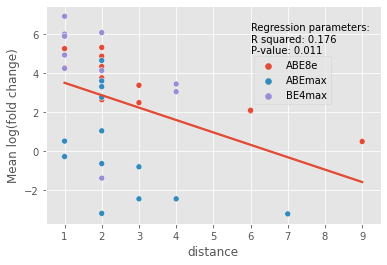

Editor: ABEmax, r^2: 0.264320, P-value: 0.072273
Editor: ABE8e, r^2: 0.691938, P-value: 0.000422
Editor: BE4max, r^2: 0.174947, P-value: 0.229008


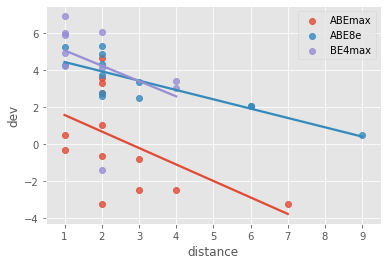

In [111]:
fig, ax = plt.subplots(figsize = (6,4))
all_dist = seqs_p_vals_df[(seqs_p_vals_df["num_of_changes"] == 2) & (seqs_p_vals_df["pos_expected"] >= 3)]
all_dist = all_dist.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()[["distance", "dev"]]
all_dist = all_dist.reset_index()
all_dist["Base Editor"] = [cur_type.split("_")[0] for cur_type in list(all_dist["type"])]

sns.regplot(x = "distance", y = "dev", data = all_dist, ci = None, scatter = False)
sns.scatterplot(x = "distance", y = "dev",hue = "Base Editor", data = all_dist)
ax.set_ylabel("Mean log(fold change)")
plt.xlim(0.5, 9.5)
r2_dist = stats.pearsonr(all_dist["distance"], all_dist["dev"])[0] **2
p_val_dist = stats.pearsonr(all_dist["distance"], all_dist["dev"])[1]

plt.annotate(f"Regression parameters:\nR squared: {r2_dist:.3}\nP-value: {p_val_dist:.3}", [6, 5])
plt.legend(loc = [0.62,0.55])

plt.show()

for editor in set(all_dist["Base Editor"]):
    sns.regplot(x = "distance", y = "dev", data = all_dist[all_dist["Base Editor"] == editor], ci = None, 
                scatter = True, label = editor)
    ax.set_ylabel("Mean log(fold change)")
    plt.xlim(0.5, 9.5)
    cur_r = stats.pearsonr(all_dist[all_dist["Base Editor"] == editor]["distance"], all_dist[all_dist["Base Editor"] == editor]["dev"])[0] **2
    cur_p = stats.pearsonr(all_dist[all_dist["Base Editor"] == editor]["distance"], all_dist[all_dist["Base Editor"] == editor]["dev"])[1]
    print("Editor: %s, r^2: %f, P-value: %f" %(editor, cur_r, cur_p))
plt.legend()

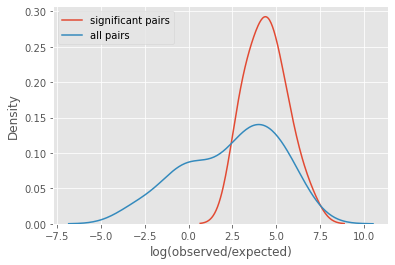

(-1.0, 1.0)

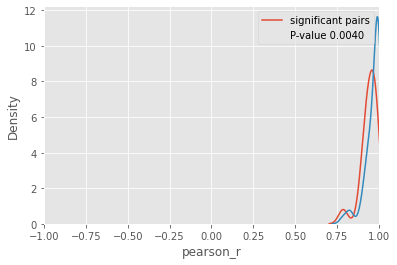

In [165]:
sns.kdeplot(seqs_p_vals_df_large_n_sig_count["dev"], label = "significant pairs")
sns.kdeplot(seqs_p_vals_df.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()["dev"], label = "all pairs")
MW_p_val = scipy.stats.mannwhitneyu(seqs_p_vals_df.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()["dev"], seqs_p_vals_df_large_n_sig_count["dev"])[1]
plt.xlabel("log(observed/expected)")

formatter = "{0:.4f}"


# plt.plot([], [], ' ', label = 'P-value %s' % formatter.format(MW_p_val))
plt.legend()

plt.show()

sns.kdeplot(seqs_p_vals_df_large_n_sig_count["pearson_r"], label = "significant pairs")
sns.kdeplot(seqs_p_vals_df.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()["pearson_r"])

MW_p_val = scipy.stats.mannwhitneyu(seqs_p_vals_df.groupby(by = ["type","A115_DMSO","seq_A","seq_B", "Reference_Sequence", "Both_changes"]).mean()["pearson_r"], seqs_p_vals_df_large_n_sig_count["pearson_r"])[1]
plt.plot([], [], ' ', label = 'P-value %s' % formatter.format(MW_p_val))
plt.legend()

plt.xlim(-1, 1)

4.794117647058823 5.931623931623932


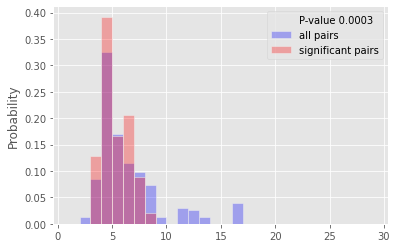

In [166]:
all_locs = []
for i in list(seqs_p_vals_df["changes_loc"]):
    [all_locs.append(j) for j in i]
sns.histplot(all_locs, bins=range(1, 30, 1), stat = "probability", label = "all pairs", color = "blue", alpha = 0.3)

sig_locs = []
for i in list(seqs_p_vals_df_large_n_sig_count["changes_loc"]):
    [sig_locs.append(j) for j in i]
    
sns.histplot(sig_locs, bins=range(1, 30, 1), stat = "probability", label = "significant pairs", color = "red", alpha = 0.3)

p_value_anova = stats.f_oneway(all_locs, sig_locs)[1]

plt.plot([], [], ' ', label = 'P-value %s' % formatter.format(p_value_anova))
plt.legend()
print(np.mean(sig_locs), np.mean(all_locs))